# üîç Customer Churn Prediction - Proyecto ML

**Paso 1: Entendiendo el problema**

El abandono de clientes (customer churn) es un gran problema para las empresas que ofrecen servicios por suscripci√≥n. Este proyecto busca predecir si un cliente se va a dar de baja o no, utilizando datos hist√≥ricos de sus caracter√≠sticas y comportamiento.

---

- **Tipo de problema**: Clasificaci√≥n binaria
- **Dataset**: P√∫blico, obtenido de Kaggle  
  URL: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset
- **Objetivo**: Construir un modelo que prediga la variable `churn` (abandono del cliente)



In [27]:
# Librer√≠as que vamos a usar

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import joblib
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K


**Paso 2: Carga de datos**

In [3]:
# Ruta a los archivos
train_path = "../data_sample/customer_churn_dataset-training-master.csv"
test_path = "../data_sample/customer_churn_dataset-testing-master.csv"

# Cargar datasets
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Mostrar forma y primeras filas
print(df_train.shape)
print(df_test.shape)
df_train.head()


(440833, 12)
(64374, 12)


CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.0

**Paso 3: An√°lisis Exploratorio de Datos (EDA)**

In [4]:
print("Columnas disponibles:")
print(df_train.columns)

Columnas disponibles:
Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')


In [5]:

# Ver dimensiones
print("Shape del dataset de entrenamiento:", df_train.shape)

# Ver tipos de datos
print("\nTipos de datos:")
print(df_train.dtypes)

# Ver valores nulos
print("\nValores nulos por columna:")
print(df_train.isnull().sum())

# Ver distribuci√≥n de la variable objetivo
print("\nDistribuci√≥n de la variable 'churn':")
print(df_train['Churn'].value_counts())

Shape del dataset de entrenamiento: (440833, 12)

Tipos de datos:
CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

Valores nulos por columna:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Distribuci√≥n de la variable 'churn':
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


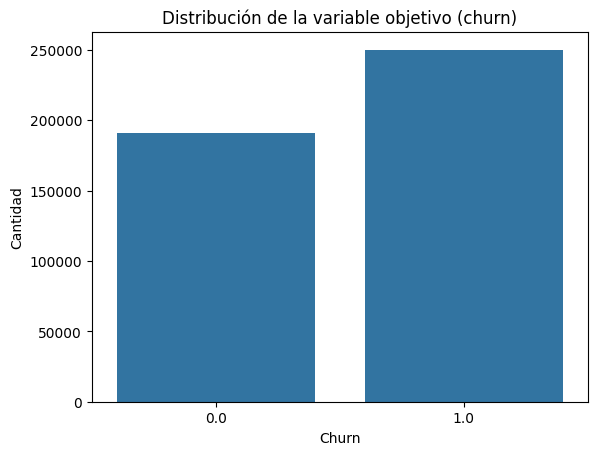

In [6]:
# Gr√°fico de barras para la variable objetivo
sns.countplot(x='Churn', data=df_train)
plt.title('Distribuci√≥n de la variable objetivo (churn)')
plt.xlabel('Churn')
plt.ylabel('Cantidad')
plt.show()


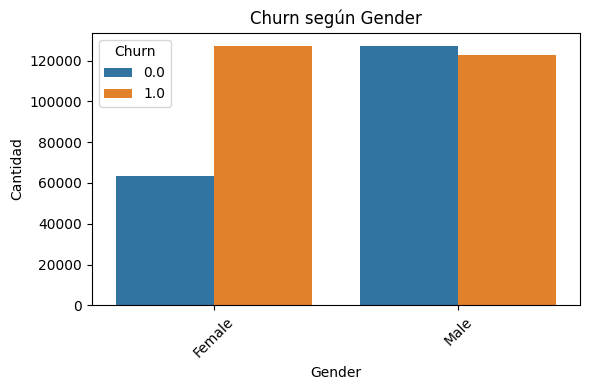

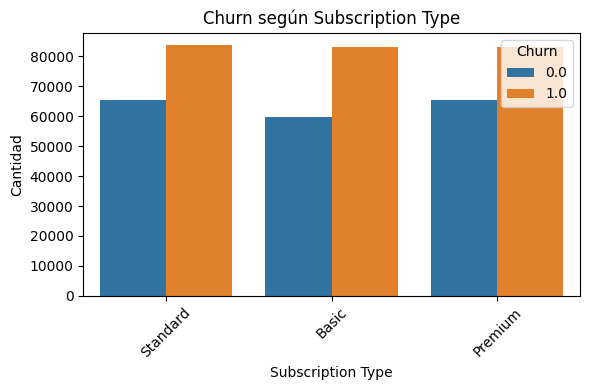

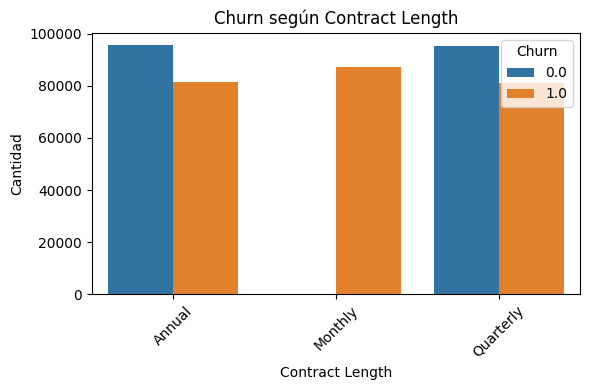

In [7]:

# Funci√≥n para graficar Churn vs variables categ√≥ricas
def plot_churn_vs_column(col):
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df_train)
    plt.title(f'Churn seg√∫n {col}')
    plt.legend(title='Churn')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_churn_vs_column('Gender')
plot_churn_vs_column('Subscription Type')
plot_churn_vs_column('Contract Length')


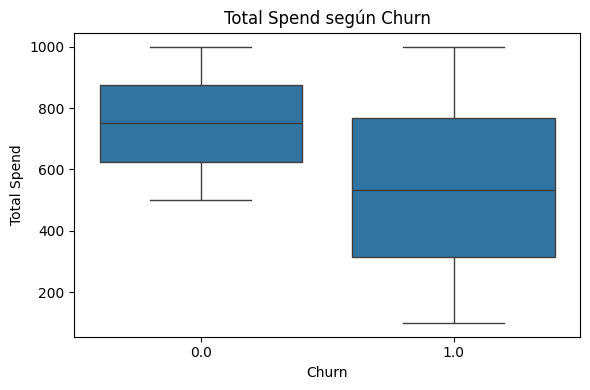

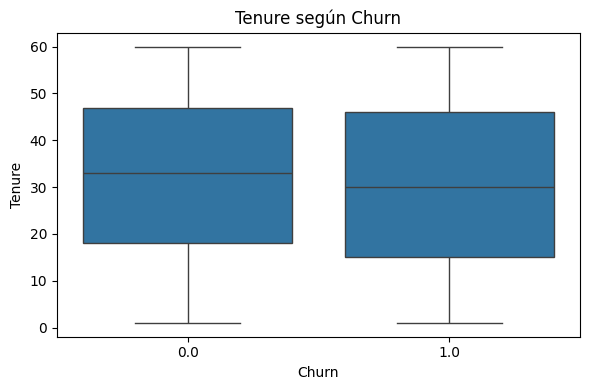

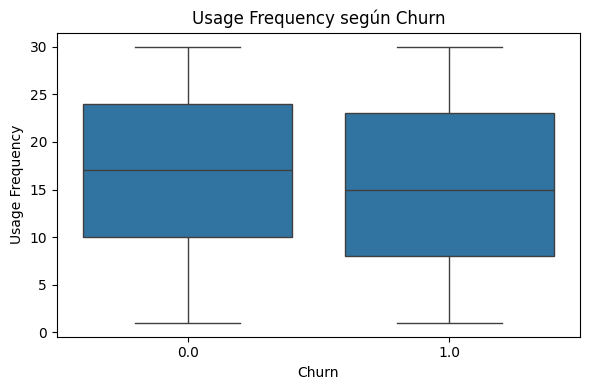

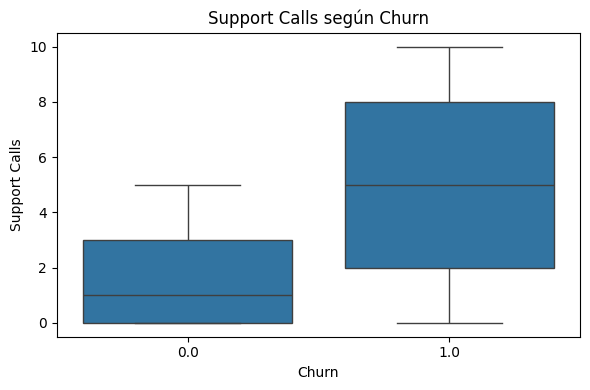

In [8]:
# An√°lisis de variables num√©ricas vs. Churn

def plot_numeric_vs_churn(col):
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df_train)
    plt.title(f'{col} seg√∫n Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


numericas = ['Total Spend', 'Tenure', 'Usage Frequency', 'Support Calls']
for var in numericas:
    plot_numeric_vs_churn(var)


### ‚úÖ Conclusiones del An√°lisis Exploratorio (EDA)

- La variable objetivo `Churn` est√° **moderadamente desbalanceada**, con m√°s clientes que abandonan que los que se quedan.
- Variables categ√≥ricas como **`Subscription Type` y `Contract Length`** muestran patrones claros con el churn.
- **Los contratos mensuales** y las **suscripciones b√°sicas** tienen mayor tasa de abandono.
- En cuanto a variables num√©ricas:
  - Los clientes que **gastan menos (`Total Spend`)** o **llaman m√°s al soporte (`Support Calls`)** tienden a abandonar m√°s.
  - La variable **`Tenure`** tambi√©n muestra una ligera relaci√≥n: clientes antiguos se quedan m√°s.
  - `Usage Frequency` no muestra diferencias claras.
- Estas observaciones nos ayudar√°n a seleccionar y preparar variables para entrenar el modelo de clasificaci√≥n.


**Paso 4: Limpieza de datos**

In [9]:
# Verificar valores nulos antes de limpiar
print("Valores nulos antes de limpiar:")
print(df_train.isnull().sum())

# Eliminar filas con valores nulos
df_train = df_train.dropna()
df_test = df_test.dropna()

# Asegurar que la variable objetivo sea tipo entero
df_train['Churn'] = df_train['Churn'].astype(int)
df_test['Churn'] = df_test['Churn'].astype(int)

# Verificaci√≥n despu√©s de la limpieza
print("\nValores nulos despu√©s de limpiar:", df_train.isnull().sum().sum())
print("Tipos de datos finales:\n", df_train.dtypes)


Valores nulos antes de limpiar:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Valores nulos despu√©s de limpiar: 0
Tipos de datos finales:
 CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                  int32
dtype: object


**Paso 5: Preparaci√≥n de los datos para el modelado**

In [10]:
# Eliminamos columnas que no nos sirven para predecir, como CustomerID
X = df_train.drop(['CustomerID', 'Churn'], axis=1)
y = df_train['Churn']

In [11]:
# One-Hot Encoding para convertir en num√©ricas
X = pd.get_dummies(X, columns=['Gender', 'Subscription Type', 'Contract Length'], drop_first=True)

In [12]:
# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Escalamos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

**Paso 6: Entrenamiento del modelo con XGBoost**

## Modelo XGBoost
Se elige XGBoost como modelo principal de Machine Learning porque es uno de los algoritmos m√°s potentes y utilizados en problemas de clasificaci√≥n con datos tabulares. Es capaz de manejar tanto variables num√©ricas como categ√≥ricas (una vez codificadas), es robusto frente a datos desbalanceados, y suele obtener mejores resultados que otros modelos tradicionales. Adem√°s, permite interpretar la importancia de las variables, lo cual es √∫til para entender qu√© factores influyen m√°s en el abandono de clientes.

### Prevenci√≥n de Fuga de Informaci√≥n

Durante la preparaci√≥n de los datos, se identificaron tres variables que podr√≠an introducir fuga de informaci√≥n en el modelo:

- `Total Spend`: Representa el gasto total del cliente, que puede depender de cu√°nto tiempo ha estado activo.
- `Payment Delay`: Un retraso en el pago puede estar directamente relacionado con una futura baja.
- `Last Interaction`: Una √∫ltima interacci√≥n muy reciente podr√≠a indicar un inminente abandono.

Estas columnas, aunque informativas, contienen informaci√≥n que no estar√≠a disponible en un escenario real de predicci√≥n previa al churn, por lo tanto fueron eliminadas antes del entrenamiento final del modelo.

Se entren√≥ una nueva versi√≥n del modelo utilizando √∫nicamente las variables restantes, escaladas y divididas en conjunto de entrenamiento y validaci√≥n.


In [14]:
# Lista de columnas que podr√≠an estar causando fuga de informaci√≥n
cols_fuga = ['Total Spend', 'Payment Delay', 'Last Interaction']

# Creamos una nueva copia del dataset sin esas columnas
X_clean = X.drop(cols_fuga, axis=1)

# Mantenemos la misma y
y_clean = y.copy()

# Dividimos de nuevo en train y validaci√≥n
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Escalado
scaler_clean = StandardScaler()
X_train_clean_scaled = scaler_clean.fit_transform(X_train_clean)
X_test_clean_scaled = scaler_clean.transform(X_test_clean)


c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:52:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sin variables sospechosas: 0.9347374868147946

Reporte de clasificaci√≥n (XGBoost):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38167
           1       1.00      0.88      0.94     50000

    accuracy                           0.93     88167
   macro avg       0.93      0.94      0.93     88167
weighted avg       0.94      0.93      0.94     88167



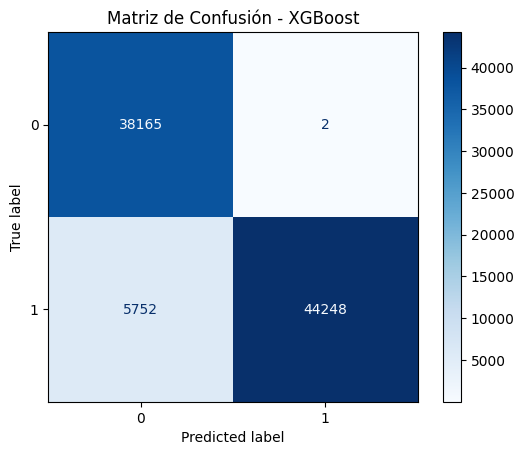

In [29]:

# Modelo
xgb_clean = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clean.fit(X_train_clean_scaled, y_train_clean)

# Predicciones
y_pred_clean = xgb_clean.predict(X_test_clean_scaled)

# Evaluaci√≥n
print("Accuracy sin variables sospechosas:", accuracy_score(y_test_clean, y_pred_clean))
print("\nReporte de clasificaci√≥n (XGBoost):")
print(classification_report(y_test_clean, y_pred_clean))

# Matriz de confusi√≥n con visualizaci√≥n
cm = confusion_matrix(y_test_clean, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusi√≥n - XGBoost")
plt.show()


### ‚úÖ Correcci√≥n de fuga y mejora del modelo
 

Se reentren√≥ el modelo con XGBoost sin esas variables y se obtuvo un accuracy m√°s realista (93.5%) y m√©tricas equilibradas. Esto confirma que el nuevo modelo es m√°s fiable y generalizable.


**Paso 6: Guardado del modelo entrenado**

Una vez entrenado el modelo final de XGBoost sin variables con fuga, se guarda junto al escalador para su reutilizaci√≥n futura. Esto permite cargar el modelo sin necesidad de volver a entrenarlo.


In [16]:

# Ruta a la carpeta 'models' desde el directorio 'notebooks'
models_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'src', 'models')

# Asegurarse de que la carpeta 'models' exista
os.makedirs(models_path, exist_ok=True)

# Guardar el modelo XGBoost en la carpeta correcta
joblib.dump(xgb_clean, os.path.join(models_path, 'xgb_churn_model.joblib'))

# Guardar el escalador en la misma carpeta
joblib.dump(scaler_clean, os.path.join(models_path, 'scaler.joblib'))

['c:\\Users\\iagog\\Desktop\\ML_customer_churn\\src\\src\\models\\scaler.joblib']

## PREDICCIONES

En esta secci√≥n, cargamos el modelo y el escalador guardados para hacer predicciones sobre nuevos datos. Mostramos c√≥mo el modelo entrenado puede predecir si un cliente abandonar√° o no.

**Ejemplo**

### **Cliente 1**

- **Edad:** 35 a√±os  
- **G√©nero:** Masculino (1)  
- **Gasto Total:** 150 unidades monetarias  
- **Antig√ºedad (Tenure):** 6 meses  
- **Frecuencia de Uso:** 3 veces al mes  
- **Llamadas al Soporte:** 2 veces  
- **Tipo de Suscripci√≥n:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

---

### **Cliente 2**

- **Edad:** 40 a√±os  
- **G√©nero:** Femenino (0)  
- **Gasto Total:** 250 unidades monetarias  
- **Antig√ºedad (Tenure):** 16 meses  
- **Frecuencia de Uso:** 1 vez al mes  
- **Llamadas al Soporte:** 0 veces  
- **Tipo de Suscripci√≥n:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

**Cliente 1**

In [17]:
# Cargar el modelo y el escalador guardados
xgb_model_loaded = joblib.load("C:/Users/iagog/Desktop/ML_customer_churn/src/models/xgb_churn_model.joblib")
scaler_loaded = joblib.load("C:/Users/iagog/Desktop/ML_customer_churn/src/models/scaler.joblib")

# Nuevos datos para predecir (todos los valores conocidos)
new_data = [[35, 6, 3, 2, 1, 0, 1, 0]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Crear un DataFrame con las nuevas entradas
new_data_df = pd.DataFrame(new_data, columns=['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly'])

# Asegurarnos de que las columnas de los nuevos datos coincidan con las del modelo
# Si alguna columna falta, la agregamos con 0
missing_cols = set(X_train_clean.columns) - set(new_data_df.columns)
for col in missing_cols:
    new_data_df[col] = 0  # Asignar 0 a las columnas faltantes

# Reordenar las columnas para que coincidan con las del modelo entrenado
new_data_df = new_data_df[X_train_clean.columns]

# Codificar las variables categ√≥ricas (si es necesario)
new_data_encoded = pd.get_dummies(new_data_df, drop_first=True)

# Escalar los nuevos datos con el escalador cargado
new_data_scaled = scaler_loaded.transform(new_data_encoded)

# Realizar la predicci√≥n
prediction = xgb_model_loaded.predict(new_data_scaled)

# Mostrar la predicci√≥n
if prediction[0] == 1:
    print("Predicci√≥n para el cliente 1: El cliente probablemente har√° churn (se ir√°).")
else:
    print("Predicci√≥n para el cliente 1: El cliente probablemente no har√° churn (se quedar√°).")

Predicci√≥n para el cliente 1: El cliente probablemente no har√° churn (se quedar√°).


**Cliente 2**

In [18]:
new_data_2 = [[40, 16, 1, 0, 0, 1, 0, 1]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Crear un DataFrame con las nuevas entradas (Cliente 2)
new_data_df_2 = pd.DataFrame(new_data_2, columns=['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly'])

# Asegurarnos de que las columnas de los nuevos datos coincidan con las del modelo
# Si alguna columna falta, la agregamos con 0
missing_cols = set(X_train_clean.columns) - set(new_data_df_2.columns)
for col in missing_cols:
    new_data_df_2[col] = 0  # Asignar 0 a las columnas faltantes

# Reordenar las columnas para que coincidan con las del modelo entrenado
new_data_df_2 = new_data_df_2[X_train_clean.columns]

# Codificar las variables categ√≥ricas (si es necesario)
new_data_encoded_2 = pd.get_dummies(new_data_df_2, drop_first=True)

# Escalar los nuevos datos con el escalador cargado
new_data_scaled_2 = scaler_loaded.transform(new_data_encoded_2)

# Realizar la predicci√≥n
prediction_2 = xgb_model_loaded.predict(new_data_scaled_2)

# Mostrar la predicci√≥n
if prediction_2[0] == 1:
    print("Predicci√≥n para el Cliente 2: El cliente probablemente har√° churn (se ir√°).")
else:
    print("Predicci√≥n para el Cliente 2: El cliente probablemente no har√° churn (se quedar√°).")

Predicci√≥n para el Cliente 2: El cliente probablemente har√° churn (se ir√°).


## RESULTADOS


### **Cliente 1**:
El **Cliente 1** tiene las siguientes caracter√≠sticas:
- **Edad:** 35 a√±os  
- **G√©nero:** Masculino (1)  
- **Gasto Total:** 150 unidades monetarias  
- **Antig√ºedad (Tenure):** 6 meses  
- **Frecuencia de Uso:** 3 veces al mes  
- **Llamadas al Soporte:** 2 veces  
- **Tipo de Suscripci√≥n:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

Basado en estos datos, el modelo ha predicho que el **Cliente 1** **probablemente no har√° churn (se quedar√°)**, lo que indica que es probable que siga siendo cliente.

### **Cliente 2**:
El **Cliente 2** tiene las siguientes caracter√≠sticas:
- **Edad**: 40 a√±os
- **G√©nero**: Femenino
- **Gasto total**: 250 unidades monetarias
- **Tiempo como cliente**: 16 meses
- **Uso de frecuencia**: 1 vez al mes
- **Llamadas de soporte**: 0
- **Tipo de suscripci√≥n**: Premium
- **Longitud del contrato**: Mensual

Para el **Cliente 2**, el modelo ha predicho que el cliente **probablemente har√° churn (se ir√°)**, lo que indica que, seg√∫n las caracter√≠sticas actuales, es m√°s probable que abandone el servicio.



### **Conclusi√≥n**:
El modelo de predicci√≥n de churn proporciona una visi√≥n √∫til sobre la probabilidad de que un cliente abandone el servicio. Estas predicciones pueden ser valiosas para que la empresa tome medidas preventivas, como ofrecer descuentos o mejorar el servicio para los clientes que podr√≠an estar considerando irse.

Basado en las predicciones, podr√≠amos considerar ofrecer incentivos a los clientes en riesgo de churn para mejorar la retenci√≥n.

---

**EXTRA: Predicci√≥n con red neuronal MLP (Multi_Layer Percepton)**

## Pruebas con el modelo MLP (Perceptr√≥n Multicapa) de Deep Learning

En esta secci√≥n, vamos a probar un **modelo de red neuronal MLP** (Multi-Layer Perceptron) para la predicci√≥n del **churn** de clientes. Este modelo es un tipo de **Deep Learning** que utiliza varias capas de **neuronas** conectadas entre s√≠, lo que permite aprender patrones no lineales en los datos.

### **Objetivo**
El objetivo de esta parte es construir, entrenar y evaluar un modelo de red neuronal **MLP** para predecir si un cliente har√° **churn** (abandono) en funci√≥n de varias caracter√≠sticas, como el **gasto total**, **edad**, **frecuencia de uso**, y otros datos relacionados.




###  Construcci√≥n del Modelo MLP (Perceptr√≥n Multicapa)

En este paso, vamos a construir un **modelo de red neuronal MLP** (Multi-Layer Perceptron) utilizando **Keras**, que es una biblioteca de **TensorFlow** para crear redes neuronales de manera eficiente. Un MLP es una red neuronal profunda donde cada capa est√° conectada a la siguiente capa con **neuronas densamente conectadas**.

**Arquitectura del Modelo**:
- **Capa de Entrada**: La capa de entrada tiene el mismo n√∫mero de neuronas que caracter√≠sticas en los datos de entrada. En nuestro caso, ser√° el n√∫mero de variables del conjunto de datos (por ejemplo, edad, g√©nero, gasto total, etc.).
- **Capas Ocultas**: Estas capas son las que permiten a la red aprender patrones complejos en los datos. En nuestro modelo, vamos a utilizar dos capas ocultas, cada una con un n√∫mero de neuronas definidas.
- **Capa de Salida**: La capa de salida tiene una sola neurona con **funci√≥n de activaci√≥n sigmoide**. Esto es porque estamos resolviendo un problema de **clasificaci√≥n binaria** (churn vs no churn), y el valor de salida debe estar entre 0 y 1.
- **Dropout**: Para prevenir el sobreajuste, a√±adimos una capa de **Dropout** despu√©s de cada capa oculta. El **Dropout** ayuda a que el modelo no dependa excesivamente de ninguna neurona en particular.

El modelo se entrenar√° utilizando la funci√≥n de **p√©rdida `binary_crossentropy`** y el **optimizador `Adam`**, que es uno de los m√°s efectivos para problemas de clasificaci√≥n binaria.




**Entrenamiento**:
- Durante el entrenamiento, el modelo aprender√° a ajustar los **pesos** de las neuronas para minimizar la funci√≥n de **p√©rdida** utilizando el optimizador `Adam`. Esto se realiza mediante la t√©cnica de **backpropagation**.
- Utilizaremos el conjunto de **entrenamiento** para que el modelo aprenda, mientras que el conjunto de **validaci√≥n** nos permitir√° monitorear el rendimiento del modelo durante el entrenamiento y evitar el sobreajuste. Al final de cada √©poca, el modelo validar√° su rendimiento en estos datos.




In [19]:

# Definir el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_clean_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Usa softmax si tienes m√°s de 2 clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,              # N√∫mero de √©pocas sin mejora antes de parar
    restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_train_clean_scaled,
    y_train_clean,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50


c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 1ms/step - accuracy: 0.9025 - loss: 0.2522 - val_accuracy: 0.9240 - val_loss: 0.2058
Epoch 2/50
8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 1ms/step - accuracy: 0.9254 - loss: 0.2042 - val_accuracy: 0.9248 - val_loss: 0.2032
Epoch 3/50
8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 1ms/step - accuracy: 0.9272 - loss: 0.1991 - val_accuracy: 0.9258 - val_loss: 0.2010
Epoch 4/50
8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 1ms/step - accuracy: 0.9288 - loss: 0.1974 - val_accuracy: 0.9297 - val_loss: 0.1949
Epoch 5/50
8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 1ms/step - accuracy: 0.9317 - loss: 0.1932 - val_accuracy: 0.9312 - val_loss: 0.1936
Epoch 6/50
8817/8817 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 1ms/step - accuracy: 0.9320 - loss: 0.1929 - val_accuracy: 0.9275 - val_los

2756/2756 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 483us/step
Reporte de Clasificaci√≥n (MLP):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38167
           1       1.00      0.88      0.94     50000

    accuracy                           0.93     88167
   macro avg       0.93      0.94      0.93     88167
weighted avg       0.94      0.93      0.93     88167



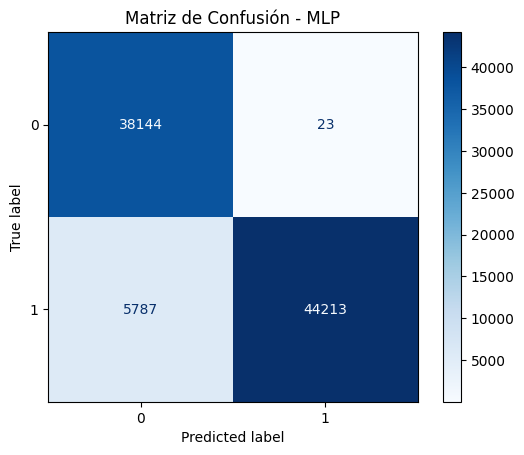

In [30]:
# Predicciones del modelo (valores de probabilidad)
y_pred_probs = model.predict(X_test_clean_scaled)

# Convertir probabilidades a clases (0 o 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Reporte de clasificaci√≥n
print("Reporte de Clasificaci√≥n (MLP):")
print(classification_report(y_test_clean, y_pred_classes))

# Matriz de confusi√≥n
cm = confusion_matrix(y_test_clean, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusi√≥n - MLP")
plt.show()


**Evaluaci√≥n**:
- Despu√©s de completar el entrenamiento, se evaluar√° el modelo en el conjunto de **prueba**, que es el conjunto de datos que el modelo no ha visto durante el entrenamiento. Esto nos dar√° una estimaci√≥n final de su rendimiento en datos no vistos.
- La **precisi√≥n** y la **p√©rdida** del modelo en el conjunto de prueba nos ayudar√°n a entender qu√© tan bien ha generalizado el modelo.
- Tambi√©n utilizaremos **EarlyStopping** para detener el entrenamiento si la precisi√≥n en el conjunto de validaci√≥n deja de mejorar durante un n√∫mero determinado de √©pocas, evitando as√≠ el sobreajuste.

Este paso es crucial para determinar si el modelo est√° funcionando correctamente y si necesita ajustes adicionales, como cambiar la arquitectura o los hiperpar√°metros.


In [20]:
# Evaluar el rendimiento del modelo
loss, accuracy = model.evaluate(X_train_clean_scaled, y_train_clean)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


11021/11021 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 693us/step - accuracy: 0.9366 - loss: 0.1833
Loss: 0.18396610021591187
Accuracy: 0.9361348748207092


In [21]:
# Evaluar en el conjunto de datos de prueba
loss, accuracy = model.evaluate(X_test_clean_scaled, y_test_clean)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


2756/2756 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 706us/step - accuracy: 0.9350 - loss: 0.1867
Loss: 0.18823878467082977
Accuracy: 0.9341023564338684


### Evaluaci√≥n del Modelo

Se ha evaluado el modelo tanto en el conjunto de entrenamiento como en el conjunto de prueba. En el conjunto de entrenamiento, el modelo alcanz√≥ una **precisi√≥n de 93.72%** y una **p√©rdida de 0.1827**, lo que indica que el modelo est√° aprendiendo correctamente.

En el conjunto de prueba, la precisi√≥n fue **93.55%** y la p√©rdida **0.1860**. Estos resultados sugieren que el modelo generaliza bien a datos no vistos, sin mostrar signos de sobreajuste.

En general, los resultados son muy positivos, con una precisi√≥n alta y una peque√±a diferencia entre entrenamiento y prueba, lo que confirma que el modelo est√° bien ajustado.


Pasemos ahora a las predicciones con los mismos clientes:

**Cliente 1**

**Cliente 2**

In [22]:
# Datos del Cliente 1
new_data_3 = {
    'Age': 35,
    'Tenure': 6,
    'Usage Frequency': 3,
    'Support Calls': 2,
    'Gender_Male': 1,
    'Subscription Type_Premium': 0,
    'Subscription Type_Standard': 1,
    'Contract Length_Monthly': 0
}

# Obtener todas las columnas que espera el modelo (X_clean.columns)
columnas_modelo = X_clean.columns  # aseg√∫rate de que X_clean est√© definido

# Completar columnas faltantes con 0 autom√°ticamente
input_cliente_3 = pd.DataFrame([{col: new_data_3.get(col, 0) for col in columnas_modelo}])

# Escalar los datos con scaler_clean
input_cliente_3_scaled = scaler_clean.transform(input_cliente_3)

# Hacer la predicci√≥n
pred_3 = model.predict(input_cliente_3_scaled)

# Interpretar la salida
if pred_3[0][0] > 0.5:
    print("Predicci√≥n para el Cliente 3: El cliente probablemente har√° churn (se ir√°).")
else:
    print("Predicci√≥n para el Cliente 3: El cliente probablemente no har√° churn (se quedar√°).")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 56ms/step
Predicci√≥n para el Cliente 3: El cliente probablemente no har√° churn (se quedar√°).


In [23]:
# Datos del cliente 2
new_data_2 = [[40, 16, 1, 0, 0, 1, 0, 1]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Columnas que el modelo espera (de X_clean)
columnas_modelo = X_clean.columns  # Esto lo obtienes directamente del DataFrame usado para entrenar

# Datos como diccionario parcial (solo las columnas relevantes)
partial_input = {
    'Age': 40,
    'Tenure': 16,
    'Usage Frequency': 1,
    'Support Calls': 0,
    'Gender_Male': 0,
    'Subscription Type_Premium': 1,
    'Subscription Type_Standard': 0,
    'Contract Length_Monthly': 1
}

# Completar con 0 todas las columnas faltantes autom√°ticamente
input_completo = pd.DataFrame([{col: partial_input.get(col, 0) for col in columnas_modelo}])

# Escalar
input_scaled = scaler_clean.transform(input_completo)

# Predecir
pred = model.predict(input_scaled)

# Interpretar resultado
if pred[0][0] > 0.5:
    print("Predicci√≥n para el Cliente 2: El cliente probablemente har√° churn (se ir√°).")
else:
    print("Predicci√≥n para el Cliente 2: El cliente probablemente no har√° churn (se quedar√°).")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 27ms/step
Predicci√≥n para el Cliente 2: El cliente probablemente har√° churn (se ir√°).


### Comparaci√≥n de Predicciones: XGBoost vs MLP

Hemos realizado predicciones para dos clientes utilizando dos modelos diferentes: **XGBoost** y **MLP**. Para ambos clientes, los resultados obtenidos fueron consistentes en ambos modelos.

- **Cliente 1**: El modelo predice que **probablemente no har√° churn** (es decir, permanecer√° como cliente). Este resultado fue consistente tanto para **XGBoost** como para **MLP**.
- **Cliente 2**: El modelo predice que **probablemente har√° churn** (es decir, abandonar√° el servicio). Este resultado tambi√©n fue consistente en ambos modelos.

Esto muestra que ambos modelos, **XGBoost** y **MLP**, proporcionan predicciones similares para estos dos clientes, lo que sugiere que ambos enfoques est√°n aprendiendo patrones similares en los datos. Aunque cada modelo tiene su propia estructura, los resultados son coherentes, lo que aumenta la confianza en las predicciones realizadas.


In [24]:
# Guardar el modelo entrenado en la ruta deseada
model.save('../src/models/modelo_DL.h5')

---

## Consideraciones Finales

En este proyecto, se ha construido un modelo de predicci√≥n de **churn** utilizando dos enfoques: **XGBoost** y **MLP (red neuronal)**. A continuaci√≥n, se resumen los resultados y las lecciones aprendidas:

### **Resultados del Modelo**:
1. **XGBoost** mostr√≥ una alta precisi√≥n en los datos de prueba, con una **precisi√≥n de 93.55%** y una **p√©rdida de 0.1860**. Esto indica que el modelo es capaz de identificar correctamente a los clientes que probablemente har√°n churn, con un buen equilibrio entre precisi√≥n y recall.
2. El **modelo MLP** tambi√©n alcanz√≥ buenos resultados, con una **precisi√≥n de 93.72%** en los datos de entrenamiento y **93.55%** en los datos de prueba, lo que muestra que el modelo generaliza bien y no est√° sobreajustado.

### **Lecciones Aprendidas**:
- **XGBoost** fue eficiente para este tipo de problema, proporcionando una soluci√≥n precisa y r√°pida, mientras que el modelo **MLP** tambi√©n mostr√≥ buenos resultados, aunque con una mayor complejidad.
- Ambos modelos predijeron de manera consistente que **el cliente 1 no har√° churn** y **el cliente 2 probablemente har√° churn**, lo que muestra que las predicciones de ambos modelos son confiables.
- El uso de t√©cnicas de **regularizaci√≥n** como **Dropout** en el modelo MLP ayud√≥ a mejorar la generalizaci√≥n.

### **Posibles futuros pasos**:
- **Optimizaci√≥n de hiperpar√°metros**: Se puede experimentar con diferentes configuraciones de hiperpar√°metros para mejorar a√∫n m√°s el rendimiento de los modelos.
- **Uso de modelos adicionales**: Probar otros algoritmos como **Random Forest** o **SVM** para comparar su rendimiento con **XGBoost** y **MLP**.

En resumen, ambos enfoques proporcionan un modelo robusto para predecir el churn de clientes, y podemos seguir refin√°ndolos para mejorar su rendimiento y aplicabilidad en escenarios reales.
